In [5]:
import xarray as xr
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("/albedo/home/orichter/pyfesom")
import pyfesom as pf
import pandas as pd
from scipy.interpolate import griddata
import pdb
import cmocean.cm as ocm
import matplotlib

In [2]:
# In[12]:

def get_topo(meshpath,quant='shelf'):
    
    mesh = pf.fesom_mesh(meshpath, abg=[0,0,0],cavity=True)
    x_fesom = mesh.x2*111e3
    y_fesom = mesh.y2*111e3
    
    topoFile = os.path.join(meshpath,quant+'.out')
    file_content = pd.read_csv(topoFile, skiprows=0, names=['topo'] )
    topo_fesom  = file_content.topo.values
    
    miso_x, miso_y = np.meshgrid(misoGrd.x,misoGrd.y)
    miso_topo = griddata((x_fesom,y_fesom),topo_fesom,(miso_x,miso_y))
    
    return np.repeat(np.expand_dims(miso_topo,0),12,0)

def get_topo_series(exp,year):
    print('calculating draft and bathy')
    #year = str(year)
    year ="{:.2f}".format(year)

    draft = get_topo(os.path.join(basedir,'timmsmesh',exp,year))
    bathy = get_topo(os.path.join(basedir,'timmsmesh',exp,year),'depth')

    dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year+'.forcing.diag.nc')
    frc = xr.open_dataset(dpath)
    if frc.time.size==13:
        frc=frc.sel(T=np.arange(1,13))
             
    ds = xr.Dataset(
          {
              "iceDraft":(['nTime','ny','nx'],draft),
              "bathymetry":(['nTime','ny','nx'],bathy)
          },
          coords={
              'time':(['nTime'],frc.time.values)
          })
    
    return ds


# In[4]:


def get_mask4d(dsTopo):
    print('calculating mask4d.')
    mask = xr.DataArray(
    np.empty((dsTopo.nTime.size,misoGrd.ny.size,misoGrd.nx.size,misoGrd.nz.size)),
    dims=('nTime',"ny",'nx','nz'))
    mask['nTime'] = dsTopo.nTime
    
    for itime in mask.nTime:
        for iz in range(misoGrd.z.size):
            depth = misoGrd.z[iz].values
            bathy = dsTopo.bathymetry[itime]
            draft = dsTopo.iceDraft[itime]
            mask[itime,:,:,iz] = (depth>bathy) & (depth<draft)
    mask = mask.astype(bool)
    mask.attrs['flag']='True = ocean / False = ice or bedrock'
    
    return mask


# In[5]:


def get_slayer_avg(d,mesh):
    avg = np.empty((12,mesh.n2d))
    idx0 = mesh.n32[:,0]
    idx1 = mesh.n32[:,1]
    for i in range(12):    
        avg[i] = (d[i,idx0]+d[i,idx1])*0.5
    return avg

def intp_fesom2miso(fd,mesh,cavity_only=True):
    
    if cavity_only:
        fx = mesh.x2[mesh.cflag==1]
        fy = mesh.y2[mesh.cflag==1]
        fd = fd[:,mesh.cflag==1]
    else:
        fx = mesh.x2
        fy = mesh.y2

    x_fesom = fx*111e3
    y_fesom = fy*111e3
    miso_x, miso_y = np.meshgrid(misoGrd.x,misoGrd.y)
    md = np.empty((12,miso_x.shape[0],miso_x.shape[1]))
    for i in range(12):
        md[i] = griddata((x_fesom,y_fesom),fd[i],(miso_x,miso_y))
        
    return md

def get_melt_series(exp,year):
    print('extracting melt rates and calculating its drivers')
    #year = str(year)
    year ="{:.2f}".format(year)

    meshpath = os.path.join(basedir,'timmsmesh',exp,year)
    mesh = pf.fesom_mesh(meshpath, abg=[0,0,0],cavity=False,get3d=True)

    dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year+'.forcing.diag.nc')
    frc = xr.open_dataset(dpath)
    if frc.time.size==13:
        frc=frc.sel(T=np.arange(1,13))

    dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year+'.oce.mean.nc')
    ocem = xr.open_dataset(dpath)
    if ocem.time.size==13:
        ocem=ocem.sel(T=np.arange(1,13))

    melt = intp_fesom2miso(frc.wnet,mesh)  

    u = get_slayer_avg(ocem.u,mesh)
    v = get_slayer_avg(ocem.v,mesh)

    ustar = np.sqrt(2.5e-3 * (u**2 + v**2 + 0.01**2))
    ustar = intp_fesom2miso(ustar,mesh)

    u = intp_fesom2miso(u,mesh)
    v = intp_fesom2miso(v,mesh)

    temp = get_slayer_avg(ocem.temp,mesh)
    tempD = temp - frc.Tsurf
    tempD = intp_fesom2miso(tempD,mesh)

    salt = get_slayer_avg(ocem.salt,mesh)
    saltD = salt - frc.Ssurf
    saltD = intp_fesom2miso(saltD,mesh)
         
    ds = xr.Dataset(
          {
              "meltRate":(['nTime','ny','nx'],melt),
              "frictionVelocity":(['nTime','ny','nx'],ustar),
              "thermalDriving":(['nTime','ny','nx'],tempD),
              "halineDriving":(['nTime','ny','nx'],saltD),
              "uBoundaryLayer":(['nTime','ny','nx'],u),
              "vBoundaryLayer":(['nTime','ny','nx'],v)
          },
          coords={
              'time':(['nTime'],ocem.time.values)
          })
    
    return ds


def get_transTS_series(exp,year):
    print('extracting TS transects')
    #year = str(year)
    year ="{:.2f}".format(year)

    meshpath = os.path.join(basedir,'timmsmesh',exp,year)
    mesh = pf.fesom_mesh(meshpath, abg=[0,0,0],cavity=False,get3d=True)

    dpath = os.path.join(basedir,'timmsdata',exp,exp+'.'+year+'.oce.mean.nc')
    ocem = xr.open_dataset(dpath)
    if ocem.time.size==13:
        ocem=ocem.sel(T=np.arange(1,13))

    x3 = np.empty_like(mesh.zcoord)
    y3 = np.empty_like(mesh.zcoord)
    for col in mesh.n32:
        col=col[col>0]-1
        x = mesh.x2[col[0]]
        y = mesh.y2[col[0]]
        x3[col]=x*111e3
        y3[col]=y*111e3
    z3 = -mesh.zcoord

    tempxz = np.ma.empty((12,misoGrd.z.size,misoGrd.x.size))
    saltxz = tempxz.copy()

    tempyz = np.ma.empty((12,misoGrd.z.size,misoGrd.y.size))
    saltyz = tempyz.copy()

    for i in range(12):

        Z,Y,X = np.meshgrid(misoGrd.z,40e3,misoGrd.x)
        maskxz = (mask4d.isel(nTime=i,ny=19) & mask4d.isel(nTime=i,ny=20))
        maskyz = (mask4d.isel(nTime=i,nx=99) & mask4d.isel(nTime=i,nx=100))

        temp = griddata((z3,y3,x3),ocem.temp[i].values,(Z,Y,X),method='nearest').squeeze()
        tempxz[i]=xr.DataArray(temp,dims=('nz','nx')).where(maskxz)

        salt = griddata((z3,y3,x3),ocem.salt[i].values,(Z,Y,X),method='nearest').squeeze()
        saltxz[i]=xr.DataArray(salt,dims=('nz','nx')).where(maskxz)

        Y,Z,X = np.meshgrid(misoGrd.y,misoGrd.z,520e3)

        temp = griddata((z3,y3,x3),ocem.temp[i].values,(Z,Y,X),method='nearest').squeeze()
        tempyz[i]=xr.DataArray(temp,dims=('nz','ny')).where(maskyz)

        salt = griddata((z3,y3,x3),ocem.salt[i].values,(Z,Y,X),method='nearest').squeeze()
        saltyz[i]=xr.DataArray(salt,dims=('nz','ny')).where(maskyz)
             
    ds = xr.Dataset(
          {
              "temperatureXZ":(['nTime','nz','nx'],tempxz),
              "salinityXZ":(['nTime','nz','nx'],saltxz),
              "temperatureYZ":(['nTime','nz','ny'],tempyz),
              "salinityYZ":(['nTime','nz','ny'],saltyz)
          },
          coords={
              'time':(['nTime'],ocem.time.values)
          })
    
    return ds

def fesom2miso(exp,years,outpath=False):
    global misoGrd, mask4d, basedir
    
    basedir = '/isibhv/netscratch/orichter/'
    
    misoGrd = xr.Dataset(
         coords={
                'x':('nx',np.arange(3.21e5,8.00e5,0.02e5)),
                'y':('ny',np.arange(1.0e3,8.0e4,2.0e3)),
                'z':('nz',np.arange(-2.5,-718.0,-5))
                   })
      
    cnt=0
    for year in years:
        print('processing year '+str(year-1000))
        
        #dsInt = get_int_series(exp,year)
        dsTopo = get_topo_series(exp,year)
        mask4d = get_mask4d(dsTopo)
        dsMelt = get_melt_series(exp,year)
        #dsBottom = get_bottomTS_series(exp,year)
        dsTrans = get_transTS_series(exp,year)
        #dsStream = get_stream_series(exp,year)

        print('merging data into single dataset for the year')
        #ds_tmp = xr.merge([dsInt, dsTopo, dsMelt, dsBottom, dsTrans, dsStream])
        ds_tmp = xr.merge([dsTopo, dsTrans, misoGrd,dsMelt])
        
        
        days = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30]))
        fdom = days+365*(year-1000)
        print('assigning time (days):',fdom)
        ds_tmp.time.values = fdom*24*3600
        
        print('assigning attributes, incl. _FillValue')
        for k,v in ds_tmp.items():
            if v.isnull().any():
                ds_tmp[k].attrs['_FillValue']=np.nan

        print('concatenating to the overloard dataset.')
        if cnt==0:
            ds = ds_tmp
            cnt+=1
        else:
            ds = xr.concat([ds,ds_tmp],dim='nTime')
            
        if outpath:
            print('saving to '+outpath)
            ds.astype('float32').to_netcdf(outpath)
            #[expt]_COM_[component]_[MODEL_CONFIG].nc

    return ds

In [3]:
ds =fesom2miso('io1056',[1000,1049,1099,1199])#,'/albedo/work/projects/oce_rio/orichter/io1056Miso.nc')

processing year 0
calculating draft and bathy
Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 0 second(s)
correct for cavity
Find bottom layer indices and save as bind
Load 3d part of the grid in 0 seconds
Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 0 second(s)
correct for cavity
Find bottom layer indices and save as bind
Load 3d part of the grid in 0 seconds
calculating mask4d.


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in greater
  result_data = func(*input_data)
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in less
  result_data = func(*input_data)


extracting melt rates and calculating its drivers
Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 0 second(s)
Find bottom layer indices and save as bind
Load 3d part of the grid in 0 seconds
extracting TS transects
Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 0 second(s)
Find bottom layer indices and save as bind
Load 3d part of the grid in 0 seconds
merging data into single dataset for the year
('assigning time (days):', array([  0,  31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334]))
assigning attributes, incl. _FillValue
concatenating to the overloard dataset.
processing year 49
calculating draft and bathy
Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 0 second(s)
correct for cavity
Find bottom layer indices and save as bind
Load 3d part of the grid in 0 seconds
Find bottom layer 

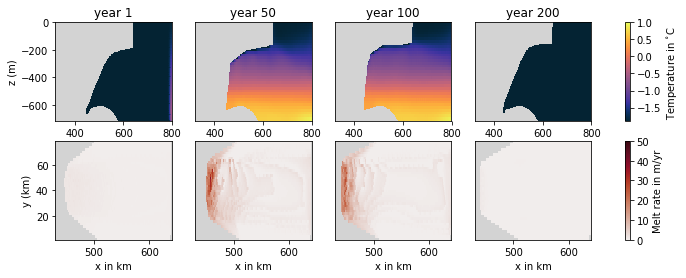

In [11]:
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(12,4))
matplotlib.rcParams.update({'font.size': 10})
ax0,ax1,ax2,ax3=axes[0,:].flatten()
for ax,time in zip(axes[0,:].flatten(),[0,12,24,36]):
    pcm = ax.pcolormesh(ds.x/1000,ds.z,ds.temperatureXZ[time],cmap=ocm.thermal,vmin=-1.9,vmax=1.)
    ax.set_title('year {}'.format(ds.time[time].values/3600/24/365+1))
    ax.set_xlabel('x (km)')
    ax.set_facecolor('lightgray')

for ax in axes[:,-3:].flatten():
    ax.get_yaxis().set_visible(False)

ax0.set_ylabel('z (m)')
fig.colorbar(pcm, ax=axes[0,:],label='Temperature in $^{\circ}$C')

ax0,ax1,ax2,ax3=axes[1,:].flatten()
for ax,time in zip(axes[1,:].flatten(),[0,12,24,36]):
    pcm = ax.pcolormesh(ds.x/1000,ds.y/1000,ds.meltRate[time]*3600*24*365,cmap=ocm.amp,vmin=0,vmax=50.)
    #ax.set_title('year {}'.format(ds.time[time].values/3600/24/365+1))
    ax.set_xlabel('x in km')
    ax.set_xlim([430,641])
    ax.set_facecolor('lightgray')
    
ax0.set_ylabel('y (km)')
fig.colorbar(pcm, ax=axes[1,:],label='Melt rate in m/yr')
#plt.savefig('./figures/idealisedTempMeltSnapshots.pdf',bbox_inches='tight',backend='pgf')
plt.savefig('./figures/idealisedTempMeltSnapshots.png',bbox_inches='tight',dpi=400)

plt.show()